## Dependencies

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
#np.random.seed(0)
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

# Data Preprocessing

## Read data

In [3]:
def read_data(sbj_i, srs_i):
    x = pd.read_csv('./data/train/subj{}_series{}_data.csv'  .format(sbj_i, srs_i), index_col='id')
    y = pd.read_csv('./data/train/subj{}_series{}_events.csv'.format(sbj_i, srs_i), index_col='id')
    return x,y

In [4]:
data = [read_data(i,j) for j in range(1,9) for i in range(1,13)]
print('There are {} series in total.'.format(len(data)))

There are 96 series in total.


## Standardization

In [5]:
scaler = StandardScaler()

all_x = pd.DataFrame()
for x,_ in data:
    all_x = pd.concat((x, all_x))

scaler.fit(all_x)
train = []
for x,y in data:
    train.append([scaler.transform(x),y])

In [6]:
# # visualization
# xcols = data[0][0].columns
# fig = plt.figure(figsize=(25,200))

# for idx,col in enumerate(xcols):
#     xx = []
#     ax = fig.add_subplot(len(xcols), 1, idx+1)
#     for x,y in train:
#         xx.append(x[col])
# #         break
#     ax.boxplot(xx, showfliers=False)
#     break

## Separate into Train/Valid

We randomly select one series from each subject to be part of the validation set.

In [7]:
valid_idxs = reversed([0,14,23,25,37,44,50,57,65,78,80,94])
valid = [train.pop(i) for i in valid_idxs]

In [8]:
len(train), len(valid)

(84, 12)

In [9]:
x,y = train[0]
display(x[:2])
display(y.iloc[:2])

array([[ 0.9353076 , -0.05334334, -1.72135124, -0.80666212,  0.06618727,
         0.54386744,  0.12806491, -0.48223347,  1.32653733,  1.32760938,
         0.39085719, -0.89306585,  4.73817947,  2.156778  ,  1.19188958,
         1.11753778, -0.44699572, -0.74099763,  1.83291025,  0.83643326,
         1.04905821,  1.34776829,  0.49217662,  2.77917604,  1.70834393,
         0.4847347 ,  0.5245576 ,  0.27292517,  0.99660636,  1.8774586 ,
         0.26778848,  0.58820446],
       [ 0.93339755, -0.01907283, -1.66025906, -0.66851354,  0.06053278,
         0.7010149 ,  0.12395646, -0.39446198,  1.56226182,  1.45132501,
         0.48487921, -0.93837847,  4.85866213,  2.27391795,  1.2843401 ,
         1.14263616, -0.34685444, -0.65210452,  1.93424751,  0.91453691,
         1.09427202,  1.24742336,  0.62571872,  2.85492979,  1.68338706,
         0.52078477,  0.42579472,  0.56862171,  1.00883616,  1.84420457,
         0.36146941,  0.6180799 ]])

,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
id,,,,,,
subj2_series1_0,0,0,0,0,0,0
subj2_series1_1,0,0,0,0,0,0


## Further Data Exploration

In this section we are going to explore the data, checking for possible label imbalances for instance.

In [10]:
len_ = 0
count = 0
for x,y in train:
    len_ += len(x)
    count += 1
print("Average series length: {}".format(len_/count))
print("Sum of all series length: {}".format(len_))

Average series length: 187071
Sum of all series length: 15714003


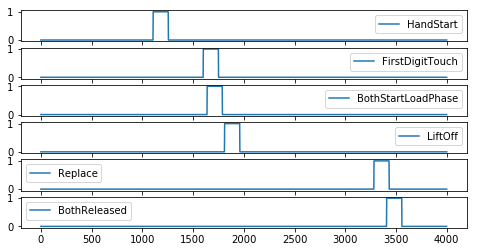

In [11]:
fig = plt.figure(figsize=(8,4))
cols = train[0][1].columns
first_ax = None

for idx,col in enumerate(cols):
    if first_ax == None:
        ax = fig.add_subplot(len(cols),1,idx+1)
        first_ax = ax
    else: 
        ax = fig.add_subplot(len(cols),1,idx+1, sharex=first_ax)
    ax.plot(train[33][1].reset_index()[col][:4000], label=col)
    ax.legend()

In the figure above we have plotted how each label evolve over time for one repetition of the grasp-and-lift movement. We can see that there is some overlapping of labels, specially for the "FirstDigitTouch", "BothStartLoadPhase" and "LiftOff" labels. Therefore, we must NOT apply a softmax function at our outputs, but a sigmoid instead.

In [12]:
last = {}
step_start = {}
step_duration = {}
step_count = {}
y_cols = train[0][1].columns
for col in y_cols:
    step_start[col] = 0
    step_duration[col] = 0
    step_count[col] = 0
    
for _,y in [train[0]]:
    for idx,row in y.reset_index().iterrows():
        for col in y_cols:
            if idx == 0:
                pass
            elif last[col] == 0 and row[col] == 1:
                step_start[col] = idx
            elif last[col] == 1 and row[col] == 0:
                step_duration[col] += idx - step_start[col]
                step_count[col] += 1
            last[col] = row[col]

step_avg_duration = {}
for col in y_cols:
    step_avg_duration[col] = step_duration[col] / step_count[col]

print step_avg_duration

{'HandStart': 150, 'LiftOff': 150, 'Replace': 150, 'BothStartLoadPhase': 150, 'FirstDigitTouch': 150, 'BothReleased': 150}


The duration of each step (the total amount of time each movement is active) is 150 for all series. We use this information to guide our search for the best window size (WS). A WS smaller than 150 is likely to miss important information that would help to identify an ongoing movement. WSs much bigger than that are likely to fill the model with unnecessary information (increasing variance). Thus, we expect to experiment with WSs ranging from 150 to 1500.

# Define Model Class (Pipeline)

In [13]:
class Model(object):
    
    def __init__(self, model_def, window_size=None):
        # define tensorflow graph
        if window_size != None:
            self.inputs = tf.placeholder(tf.float32, [None, window_size, 32])
            self.logits = model_def(self.inputs, window_size)
        else:
            self.inputs = tf.placeholder(tf.float32, [None, 32])
            self.logits = model_def(self.inputs)
        self.window_size = window_size
        
        self.labels = tf.placeholder(tf.float32, [None,  6])
        self.preds = tf.nn.sigmoid(self.logits)      
        self.cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.logits, labels=self.labels))
        
    
    def set_data(self, train, valid):
        self.train = train
        self.valid = valid
        
    def fit(self, epochs, batch_size, batches_gen, lr=0.001):
        self.optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(self.cost)
        self.sess = tf.Session()
        start_time = time.time()
        self.sess.run(tf.global_variables_initializer())
        
        # loop through epochs
        for e in range(epochs):
            loss = 0
            n_total_batches = 0
            partial_loss = 0; partial_n_batches_count = 0
            print_partial_loss_every = 1000000//batch_size
#             print_validation_every = 5500000//batch_size # 5.5M is around 1/3 of an epoch
            # loop through training series (and subjects)
            for xx,yy in batches_gen(self.train, batch_size, self.window_size, shuffle=True):
                _, res = self.sess.run([self.optimizer, self.cost], feed_dict={self.inputs: xx, self.labels: yy}) # train (update weights)
                loss += res # calculate loss
                n_total_batches += 1
                partial_loss += res; partial_n_batches_count += 1 # calculate partial loss
                
                if n_total_batches % print_partial_loss_every == 0:
                    loss_print = partial_loss/partial_n_batches_count # get mean loss to make loss comparable among different batch sizes
                    print("Epoch: {},\tBatch: {},\tMean Loss (last batches): {}".format(e, n_total_batches, loss_print))
                    partial_loss = 0; partial_n_batches_count = 0
#                 if n_total_batches % print_validation_every == 0:
#                     print("Validating...")
#                     valid_mean_auc = self.validate(batch_size, batches_gen)
#                     print("Valid Mean AUC: {}".format(valid_mean_auc))
            
            # print train and valid information
            loss /= n_total_batches # get mean loss to make loss comparable among different batch sizes
            valid_mean_auc = self.validate(batch_size, batches_gen)
            print("-----")
            print("Epoch: {},\tBatch: ----,\tMean Loss (epoch): {},\tValid Mean AUC: {}".format(e, loss, valid_mean_auc))
            print("-----")

        train_time = time.time() - start_time
        print("Model was trained in {} seconds.".format(train_time))
        
        
    def validate(self, batch_size, batches_gen):
        """Calculates the mean ROC AUC."""
        total_predictions = []
        total_labels = pd.DataFrame()
        for xx,yy in batches_gen(self.valid, batch_size, self.window_size, shuffle=False):
            predictions = self.sess.run(self.preds, feed_dict={self.inputs: xx})
            total_predictions.extend(predictions)
            total_labels = pd.concat((total_labels, yy))
        mean_auc = roc_auc_score(total_labels, total_predictions, average='macro')
        return mean_auc

# Models

In [14]:
def feedforward_nn(inputs):
    l1 = tf.layers.dense(inputs, 16)
    l2 = tf.layers.dense(l1    , 10)
    l3 = tf.layers.dense(l2    ,  6)
    return l3
            
def feedforward_batches_gen(xy_series, batch_size, window_size=None, shuffle=False):
    """Generate batches of length `batch_size` from a list of (features, labels) tuples."""
    xy_indexes = np.arange(len(xy_series))
    if shuffle: np.random.shuffle(xy_indexes)
    for i in xy_indexes:
        x,y = xy_series[i]
        n_batches = (len(x) + batch_size - 1) // batch_size
        for b in range(n_batches): # ceil division to do not discard datapoints
            # slice features and labels to the current batch interval
            xx = x[batch_size*b : batch_size*(b+1)]
            yy = y[batch_size*b : batch_size*(b+1)]
            yield xx, yy

In [57]:
def conv_nn(inputs, window_size, n_filters=64, kernel_size=3, strides=1, dense_size=128): # Bx1024x32 (supposing window_size=1024 and features=32)
    lconv = tf.layers.conv1d(inputs, filters=n_filters, kernel_size=kernel_size, strides=strides, activation=tf.nn.relu, padding='same') # Bx1024x64
    lpool = tf.layers.max_pooling1d(lconv, pool_size=2, strides=2, padding='same') # Bx512x64
    lflat = tf.reshape(lpool, [-1, (window_size/2)*n_filters/strides]) # Bx(512*64)
    ldense = tf.layers.dense(lflat, dense_size, activation=tf.nn.relu) # Bx128
    logits = tf.layers.dense(ldense, 6) # Bx6
    return logits

def conv_nn_2(inputs, window_size): # Bx1024x32 (supposing window_size=1024 and features=32)
    # b x ws x 32
    lconv = tf.layers.conv1d(inputs, filters=32, kernel_size=3, strides=2, activation=tf.nn.relu, padding='same')
    # b x ws/2 x 32
    lconv2 = tf.layers.conv1d(lconv, filters=16, kernel_size=3, strides=2, activation=tf.nn.relu, padding='same')
    # b x ws/4 x 16
    lpool = tf.layers.max_pooling1d(lconv2, pool_size=2, strides=2, padding='same') # pooling does not affect channels
    # b x ws/8 x 16
    lflat = tf.reshape(lpool, [-1, (window_size/8)*16]) # flatten to apply dense layer
    ldense1 = tf.layers.dense(lflat, 256, activation=tf.nn.relu)
    ldense2 = tf.layers.dense(ldense1, 32, activation=tf.nn.relu) 
    logits = tf.layers.dense(ldense2, 6)
    return logits

def strided_axis0(a, L):
    """Creates a view into the input array.
    Taken from https://stackoverflow.com/a/43413801/5103881
    """
    # Store the shape and strides info
    shp = a.shape
    s  = a.strides

    # Compute length of output array along the first axis
    nd0 = shp[0]-L+1

    # Setup shape and strides for use with np.lib.stride_tricks.as_strided
    # and get (n+1) dim output array
    shp_in = (nd0,L)+shp[1:]
    strd_in = (s[0],) + s
    return np.lib.stride_tricks.as_strided(a, shape=shp_in, strides=strd_in, writeable=False)

def conv_batches_gen(xy_series, batch_size, window_size, shuffle=False):
    """Generate batches of length `batch_size` from a list of (features, labels) tuples."""
    xy_indexes = np.arange(len(xy_series))
    if shuffle: np.random.shuffle(xy_indexes)
    for i in xy_indexes:
        x,y = xy_series[i]
        x_slices = strided_axis0(x, window_size)
        y_slices = y.iloc[window_size-1:] # we cannot fit any data point before (window_size - 1)
        n_batches = (len(x_slices) + batch_size - 1) // batch_size # trick to ceil using floor division
        for b in range(n_batches):
            yield x_slices[batch_size*b : batch_size*(b+1)], y_slices.iloc[batch_size*b : batch_size*(b+1)]

# Train and Validate models

There are 12 subjects and 8 series. To train using all data takes a long period of time. In order to speed up the model selection and hyperparameter tuning we use data from one subject only (subject #1). This corresponds to taking the first 7 training series and the first validation series.

In [58]:
train_ms = train
valid_ms = valid[:1]

In [63]:
nn = Model(conv_nn_2, window_size=1024)
nn.set_data(train_ms, valid_ms)
nn.fit(
    epochs=1000,
    batch_size=1024,
    batches_gen=conv_batches_gen,
)

Epoch: 0,	Batch: 976,	Mean Loss (last batches): 0.145131434088
Epoch: 0,	Batch: 1952,	Mean Loss (last batches): 0.112968327311
Epoch: 0,	Batch: 2928,	Mean Loss (last batches): 0.12677082369
Epoch: 0,	Batch: 3904,	Mean Loss (last batches): 0.0796978171415
Epoch: 0,	Batch: 4880,	Mean Loss (last batches): 0.104712334079
Epoch: 0,	Batch: 5856,	Mean Loss (last batches): 0.0877261946894
Epoch: 0,	Batch: 6832,	Mean Loss (last batches): 0.113694066458
Epoch: 0,	Batch: 7808,	Mean Loss (last batches): 0.103212157959
Epoch: 0,	Batch: 8784,	Mean Loss (last batches): 0.097332759139
Epoch: 0,	Batch: 9760,	Mean Loss (last batches): 0.0687983191268
Epoch: 0,	Batch: 10736,	Mean Loss (last batches): 0.100042946674
Epoch: 0,	Batch: 11712,	Mean Loss (last batches): 0.0908773105772
Epoch: 0,	Batch: 12688,	Mean Loss (last batches): 0.0894502694037
Epoch: 0,	Batch: 13664,	Mean Loss (last batches): 0.0670513886708
Epoch: 0,	Batch: 14640,	Mean Loss (last batches): 0.104065466332
-----
Epoch: 0,	Batch: ----,	Me

Epoch: 7,	Batch: 11712,	Mean Loss (last batches): 0.0745107319818
Epoch: 7,	Batch: 12688,	Mean Loss (last batches): 0.0926317198729
Epoch: 7,	Batch: 13664,	Mean Loss (last batches): 0.091617249831
Epoch: 7,	Batch: 14640,	Mean Loss (last batches): 0.0677248359166
-----
Epoch: 7,	Batch: ----,	Mean Loss (epoch): 0.0830947192922,	Valid Mean AUC: 0.788399838817
-----
Epoch: 8,	Batch: 976,	Mean Loss (last batches): 0.0859610742091
Epoch: 8,	Batch: 1952,	Mean Loss (last batches): 0.0716566438282
Epoch: 8,	Batch: 2928,	Mean Loss (last batches): 0.0815766102336
Epoch: 8,	Batch: 3904,	Mean Loss (last batches): 0.0715843517102
Epoch: 8,	Batch: 4880,	Mean Loss (last batches): 0.1004473948
Epoch: 8,	Batch: 5856,	Mean Loss (last batches): 0.0911667081598
Epoch: 8,	Batch: 6832,	Mean Loss (last batches): 0.0792035839272
Epoch: 8,	Batch: 7808,	Mean Loss (last batches): 0.106146194623
Epoch: 8,	Batch: 8784,	Mean Loss (last batches): 0.0661416886828
Epoch: 8,	Batch: 9760,	Mean Loss (last batches): 0.0652

KeyboardInterrupt: 

# Debug

In [9]:
len(train)

96

In [64]:
nn.set_data(train, valid)

start_time = time.time()
auc = nn.validate(1024, conv_batches_gen)
print("AUC: {}".format(auc))
print('Elapsed time: {}'.format(time.time() - start_time))

AUC: 0.889941700921
Elapsed time: 552.739305973


In [21]:
loss = 0
n_total_batches = 0
for xx,yy in conv_batches_gen([train[0]], 256, 1024, shuffle=True):
    loss += nn.sess.run(nn.cost, feed_dict={nn.inputs: xx, nn.labels: yy})
    n_total_batches += 1
print loss / n_total_batches

0.07339391998329657


In [22]:
nn.set_data(train, [valid[1]])
nn.validate(256, conv_batches_gen)

0.613213468633827

In [129]:
g = conv_batches_gen([valid[8]], batch_size=4096, window_size=1024, shuffle=True)

In [131]:
# testing time
start_time = time.time()
for x,y in g:
    pass
print('Elapsed time: {}'.format(time.time() - start_time))

Elapsed time: 5.29289245605e-05


In [125]:
x,y = next(g)

In [126]:
x.shape

(4096, 1024, 32)

In [128]:
y.shape

(4096, 6)

In [117]:
x,y = train[0]

In [118]:
x.shape

(291874, 32)

In [119]:
y.iloc[3:6]

,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
id,,,,,,
subj2_series1_3,0,0,0,0,0,0
subj2_series1_4,0,0,0,0,0,0
subj2_series1_5,0,0,0,0,0,0


In [ ]:
def ttt(a):
    return a

In [ ]:
x,y = train[0]

In [ ]:
np.array(y)[np.array([5,6,9])]

In [ ]:
sl = np.array([1,2,3,4,5])
x[np.array([[1,2,3],[2,3,4]])]

In [ ]:
# debugging
xx = train[0][0][0:100]
yy = train[0][1][0:100]
predictions = sess.run(logits, feed_dict={inputs: xx, labels: yy})
print predictions

In [ ]:
train[0][1][0:100]

In [ ]:
sum_ = 0
for x,y in valid:
    sum_ += len(x)
sum_

In [ ]:
roc_auc_score([1,1,0], [0.95, 0.86, 0.02], average='macro')

In [ ]:
a = [0:10]